In [1]:
# Import necessary modules
import py_ncdiff
import os
import logging
import numpy as np

# Setup logging so info / debug -> stdout instead of stderr
py_ncdiff.init_logging()
logger = logging.getLogger(__name__)

In [2]:
baseline_case = 'C1850ECO.T62_g37.ciso.trunk_20180716'
new_case = 'C1850ECO.T62_g37.ciso.trunk_20180705'

root_dir = os.path.join(os.path.sep,'glade','scratch_new','mlevy')
if not os.path.isdir(root_dir):
    root_dir = os.path.join(os.path.sep,'sshfs') + root_dir

if os.path.isdir(os.path.join(root_dir,new_case)):
    file1 = os.path.join(root_dir,new_case,'run',new_case+'.pop.h.0001-01-03.nc')
    file2 = os.path.join(root_dir,'baselines','single_run',baseline_case+'.pop.h.0001-01-03.nc')
    nc_test = py_ncdiff.netCDF_comp_class(file1, file2,quiet=True,is_POP=True)
else:
    logger.error("Can not find root directory (may need to mount sshfs drive)")


Comparing /sshfs/glade/scratch_new/mlevy/C1850ECO.T62_g37.ciso.trunk_20180705/run/C1850ECO.T62_g37.ciso.trunk_20180705.pop.h.0001-01-03.nc and /sshfs/glade/scratch_new/mlevy/baselines/single_run/C1850ECO.T62_g37.ciso.trunk_20180716.pop.h.0001-01-03.nc
-----
Baseline modified: Thu Jul 19 11:43:37 2018
New file modified: Thu Jul 19 11:08:57 2018
-----


In [3]:
# Set to true if you want to run the tests in this notebook
run_tests = False

if run_tests:
    nc_test.compare_variable_names()
    nc_test.compare_variable_type_and_dims()
    nc_test.compare_metadata()
    nc_test.compare_values()
    err_cnt = nc_test.parse_results()

/Users/mlevy/miniconda3/envs/jupyter/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


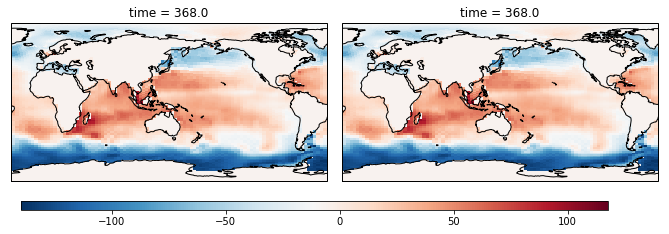

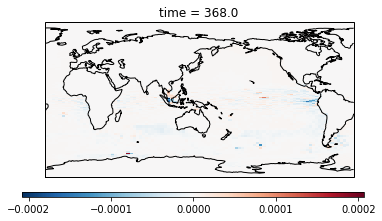

In [4]:
# Set up modules for plotting
import matplotlib.ticker
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

# Pick variable to plot (kwargs will look only at surface for 3D fields)
var_to_plot = 'SSH'
kwargs = dict()
kwargs['time']=0
if 'z_t' in nc_test.baseline['ds'][var_to_plot].coords:
    kwargs['z_t']=0

ds_baseline = nc_test.baseline['ds']
ds_new_file = nc_test.new_file['ds']
diff_field = ds_new_file[var_to_plot] - ds_baseline[var_to_plot]

# Compute min and max for contours
glo_min = np.min([np.amin(ds_baseline[var_to_plot]), np.amin(ds_new_file[var_to_plot])])
glo_max = np.max([np.amax(ds_baseline[var_to_plot]), np.amax(ds_new_file[var_to_plot])])

# Should difference contours be centered around 0?
diff_contours_centered_0 = True
if diff_contours_centered_0:
    diff_max = np.amax(np.abs(diff_field))
    diff_min = -diff_max
else:
    diff_min = np.amin(diff_field)
    diff_max = np.amax(diff_field)


# Two panels of fig1 (left is baseline, right is new_file)
fig1, (ax1, ax2)=plt.subplots(nrows=1, ncols=2, figsize=(10,2.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=141), sharey=True))
img1 = ds_baseline[var_to_plot].isel(**kwargs).plot.pcolormesh(ax=ax1, x='TLONG', y='TLAT', vmin=glo_min, vmax=glo_max, cmap='RdBu_r', transform=ccrs.PlateCarree());
img1.colorbar.remove()
ax1.coastlines()
img2 = ds_new_file[var_to_plot].isel(**kwargs).plot.pcolormesh(ax=ax2, x='TLONG', y='TLAT', vmin=glo_min, vmax=glo_max, cmap='RdBu_r', transform=ccrs.PlateCarree());
img2.colorbar.remove()
ax2.coastlines()

# Colorbar at bottom
cax1 = fig1.add_axes([0.1, -0.1, 0.815, 0.05])
cb = fig1.colorbar(img1, cax=cax1, orientation='horizontal')
plt.tight_layout()

# Single panel for fig2 (just showing difference)
fig2, ax3 = plt.subplots(figsize=(5,2.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=141)))

img3 = diff_field.isel(**kwargs).plot.pcolormesh(ax=ax3, x='TLONG', y='TLAT', vmin=diff_min, vmax=diff_max, cmap='RdBu_r', transform=ccrs.PlateCarree());
img3.colorbar.remove()
ax3.coastlines()
cax2 = fig2.add_axes([0.05, -0.05, 0.95, 0.025])
cb2 = fig2.colorbar(img3, cax=cax2, orientation='horizontal')
cb2.locator = matplotlib.ticker.MaxNLocator(nbins=5)
cb2.update_ticks()
plt.tight_layout()